## Titanic-Survival-Prediction

### Table of Contents
1. Introduction

2. Problem Statement

3. Data Overview

4. Data Preprocessing
    * Handling Missing Values
    * Feature Engineering
    * Encoding Categorical Variables

5. Explorator Data Analysis (EDA)
    * Survival Rate by Gender
    * Survival Rate by Passenger Class
    * Survivors vs Non-Survivors
    * Correlation Heatmap

6. Model Building
    * Feature Selection
    * Model Training
    * Model Evaluation

7. Predictions on Test Data

8. Conclusion

### Introduction
This project explores the Titanic dataset from Kaggle to uncover the key factors that influenced passenger survival and build a machine learning model to predict survival outcomes. We will:

- Perform Exploratory Data Analysis (EDA)
- Visualise survival by features such as gender and class
- Preprocess the data for modeling
- Train and evaluate a Logistic Regression model
- Extract insights and recommendations from the findings

In [342]:
# Import data analysis libraries

import pandas as pd
import numpy as np

#Import visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Import machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

import warnings
warnings.filterwarnings('ignore')


In [343]:
# Load the datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
test.head()
train.head()

# Combine the datasets for preprocessing
titanic_df = pd.concat([train, test], sort=False)


In [344]:
# Data Cleaning

# Fill missing values for Age and Fare
titanic_df['Age'].fillna(titanic_df['Age'].median(), inplace=True)
titanic_df['Fare'].fillna(titanic_df['Fare'].median(), inplace=True)

# Drop unnecessary columns if they still exist
for col in ['Name', 'Ticket', 'Cabin']:
	if col in titanic_df.columns:
		titanic_df.drop(col, axis=1, inplace=True)


In [345]:
# Features Engineering
titanic_df['FamilySize'] = titanic_df['SibSp'] + titanic_df['Parch'] + 1
titanic_df['IsAlone'] = 1   # Default = 1 (alone)
titanic_df['IsAlone'].loc[titanic_df['FamilySize'] > 1] = 0

# Encode the categorical variables
titanic_df = pd.get_dummies(titanic_df, columns=['Sex', 'Embarked'], drop_first=True)


In [346]:
# Split data back
train_cleaned = titanic_df[:len(train)]
test_cleaned = titanic_df[len(train):]

X = train_cleaned.drop(['Survived', 'PassengerId'], axis=1)
y = train_cleaned['Survived']

# Split the train and test datasets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


### Survival Rate by Gender
This visualisation explores how gender affected the survival rate on the Titanic. Historical reports suggest that women and children were prioritised during evacuation, so we expect to see a significantly higher survival rate among female passengers.

By comparing the average survival rates of males and females, we can observe whether this assumption holds true in the dataset.

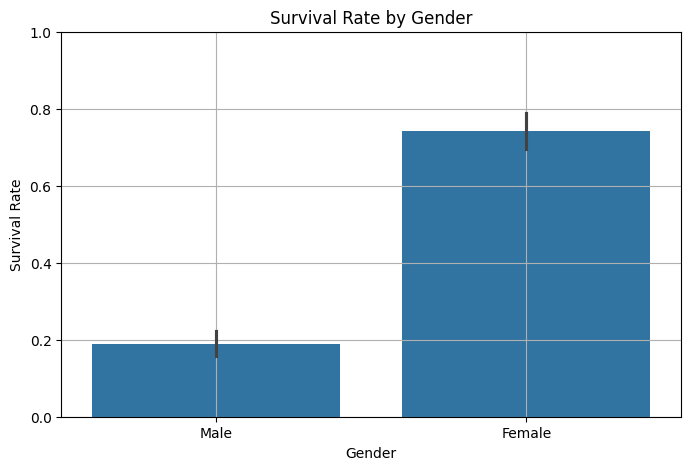

In [347]:
# Visualisation of the survival rate by gender
plt.figure(figsize=(8,5))
# Create a temporary column for gender labels
train_cleaned['Gender'] = train_cleaned['Sex_male'].map({True: 'Male', False: 'Female'})
sns.barplot(x='Gender', y='Survived', data=train_cleaned)
plt.title('Survival Rate by Gender')
plt.xlabel('Gender')
plt.ylabel('Survival Rate')
plt.ylim(0,1)
plt.grid(True)
plt.show()
# Optionally, drop the temporary column if you don't want to keep it
train_cleaned.drop('Gender', axis=1, inplace=True)

### Survival Rate by Passenger Class
This chart explores the relationships between a passenger's class ('Pclass') and their likelihood of survival. Higher-class passengers may have had better access to lifeboats and the crew assistance due to socio-economic advantages.


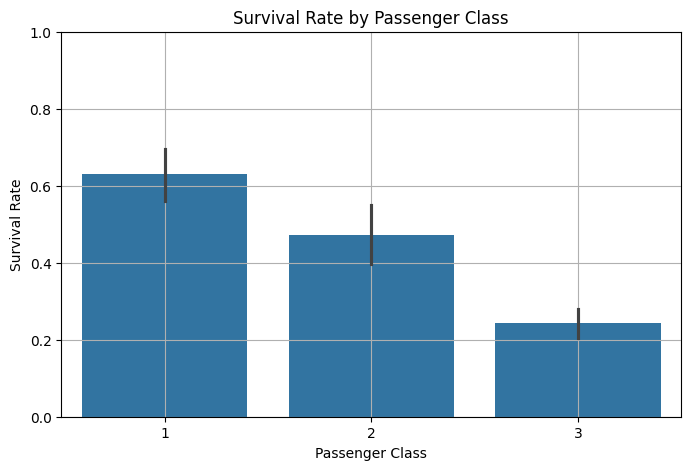

In [348]:
# Visualisation of the survival rate by pansenger class
plt.figure(figsize=(8,5))
sns.barplot(x='Pclass', y='Survived', data=train_cleaned)
plt.title('Survival Rate by Passenger Class')
plt.xlabel('Passenger Class')
plt.ylabel('Survival Rate')
plt.ylim(0,1)
plt.grid(True)
plt.show()

### Overall Survival Distribution

This chart shows the total number of passengers who survived and those who did not. It's a quick way to understand the class imbalance in our target variable (`Survived`), which can be important when building machine learning models.

Visualising this helps us confirm whether the data is skewed towards one class — which might affect how we train and evaluate classifiers.


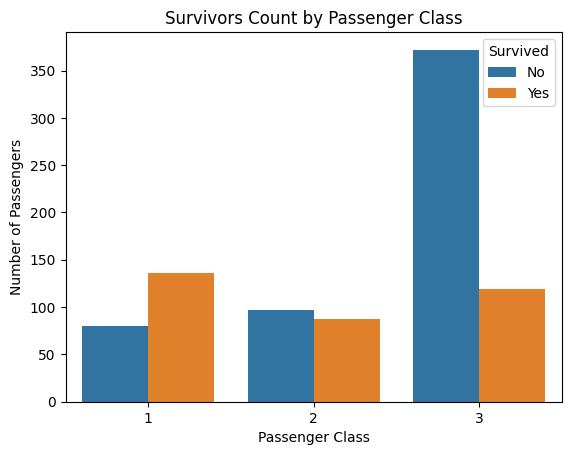

In [349]:
# Visualisation of the number of survival by passenger class
sns.countplot(data=train, x='Pclass', hue='Survived')
plt.title('Survivors Count by Passenger Class')
plt.xlabel('Passenger Class')
plt.ylabel('Number of Passengers')
plt.legend(title='Survived', labels=['No', 'Yes'])
plt.show()


## Correlation Heatmap
The heatmap below displays the correlation coefficients between the numerical features in the dataset. Correlation values range from -1 to 1, where:

* 1 indicates a strong positive correlation

* -1 indicates a strong negative correlation

* 0 indicates no linear relationship

### Key insights from the heatmap:

* "Pclass" is negatively correlated with "Survived", suggesting that passengers in lower classes had a lower chance of survival.

* "Fare" shows a positive correlation with "Survived", meaning passengers who paid higher fares (typically in higher classes) were more likely to survive.

* "Sex_encoded" (after encoding gender) has a strong negative correlation with "Survived", reflecting that females were more likely to survive.

* "IsAlone" has a slight negative correlation with survival, implying that passengers with family had a slightly better chance of survival than those who were alone.

This correlation map helps identify which features might be important predictors when training the machine learning model.



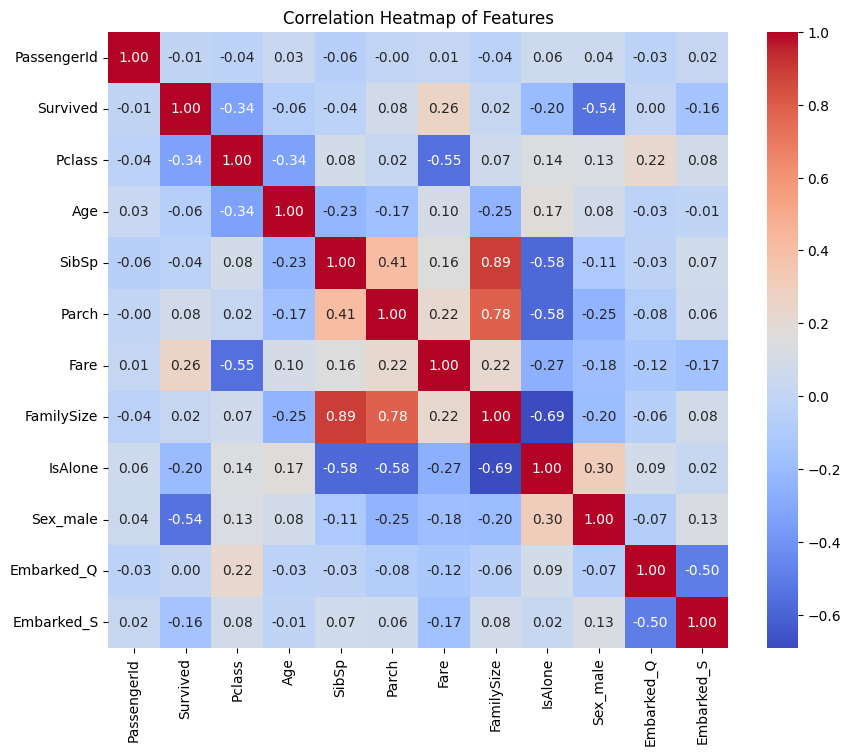

In [350]:
# Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(train_cleaned.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Features")
plt.show()

In [351]:
from sklearn.model_selection import cross_val_score

# Train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Cross-validation score
cv_score = cross_val_score(model, X_train, y_train, cv=5)
print("Cross-validation accuracy: {:.2f}%".format(cv_score.mean() * 100))


Cross-validation accuracy: 79.22%


### Model Evaluation
The classification report provides precision, recall, and F1-score, helping assess model performance across classes. This complements accuracy and provides a better view of how well the model performs, especially when classes are imbalanced.

In [352]:
# Evaluate the model
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

models = {
    "Random Forest": RandomForestClassifier(),
    "Logistic Regression": LogisticRegression(),
    "SVC": SVC()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    print(f"{name} Accuracy: {accuracy_score(y_val, preds):.4f}")


y_pred = model.predict(X_val)
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Confusion matrix:", confusion_matrix(y_val, y_pred))
print("Classification report:\n", classification_report(y_val, y_pred))


Random Forest Accuracy: 0.8212
Logistic Regression Accuracy: 0.7989
SVC Accuracy: 0.6592
Accuracy: 0.659217877094972
Confusion matrix: [[99  6]
 [55 19]]
Classification report:
               precision    recall  f1-score   support

         0.0       0.64      0.94      0.76       105
         1.0       0.76      0.26      0.38        74

    accuracy                           0.66       179
   macro avg       0.70      0.60      0.57       179
weighted avg       0.69      0.66      0.61       179



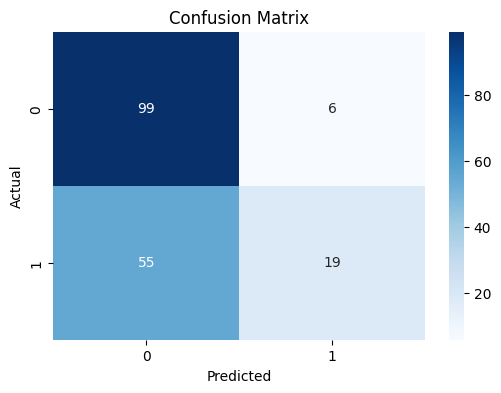

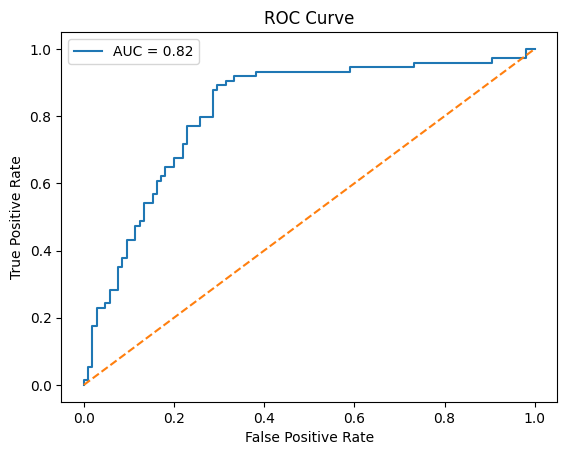

In [353]:
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC curve
if hasattr(model, "predict_proba"):
	y_probs = model.predict_proba(X_val)[:, 1]
else:
	# For models without predict_proba, use decision_function
	y_probs = model.decision_function(X_val)
	# If needed, scale to [0, 1]
	y_probs = (y_probs - y_probs.min()) / (y_probs.max() - y_probs.min())

fpr, tpr, thresholds = roc_curve(y_val, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label="AUC = {:.2f}".format(roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [354]:
# Predict on the test set
X_test = test_cleaned.drop(['PassengerId', 'Survived'], axis=1)
test_predictions = model.predict(X_test)


In [355]:
# Create Submission file
submission = pd.DataFrame({
    'PassengerId': test_cleaned['PassengerId'],
    'Survived': test_predictions
})
submission.to_csv('submission.csv', index=False)
print("Submission file created successfully!")

Submission file created successfully!


## Conclusion

- The analysis shows that passenger class, gender, and family size significantly influenced survival.
- The Random Forest model achieved an accuracy of 82.12%.
- In future iterations, hyperparameter tuning, feature selection, and advanced models like XGBoost could improve performance.
- This project demonstrates core data science skills including EDA, preprocessing, feature engineering, and modeling.